In [1]:
%matplotlib inline
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=9f2624e257888caae592eb483920c250f3c5ab1f79c7e7cb71a56ed8ef7ac6e8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget



# Computer Vision Tutorial

In this tutorial, we will recall how to train a Convolutional Neural Network (CNN) for image classification and how to use transfer learning. You can read more about the transfer learning at [cs231n notes](https://cs231n.github.io/transfer-learning/.)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

Therefore there exists three main scenarios when training a CNN:
-  **Train the network from scratch**: we randomly initialize the weights in every layers.
-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: we load the pretrained
   weights and we freeze the weights of all layers except for the last fully connected layer. This layer is replaced with a new one with random weights and it is the only layer trained.

## The most common CNN: The ResNet
In the following we will put in practice these scenarios by training (or finetuning) the most commonly used CNN: the Residual Network (ResNet).
This network deeply reduces the problem of *vanishing gradients* thanks to the employment of *skipping connections*.  The figure in the following better illustrates this architectural trick:

<div>
<img src="https://www.researchgate.net/publication/325430477/figure/fig4/AS:633970848960514@1528161837288/An-illustration-of-the-modified-deep-residual-network-ResNetPlus-structure-The-blue.png" width="500"/>
</div>


This allows us to train CNN in a very stable (and easy) way.

<div>
<img src="https://miro.medium.com/max/1384/1*r1c1C2RY8tkR_SvdV6aHsw.png" height="180"/>
</div>

There exist several ResNet variants, suitable for different learning problems, but they all achieve very high classification performance (even the smallest ResNet 18). All Resnet variants are implemented in [torchvision](https://pytorch.org/vision/main/models.html) which also provides their pretrained version on ImageNet.

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import wget
import zipfile
import shutil


cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet composed of these two classes only.

We use the "wget" and "ZipFile" libraries to download and extract the data to the /data directory.
<!-- .. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory. -->

In [3]:
data_dir = 'hymenoptera_data'

if os.path.exists(data_dir):
    shutil.rmtree(data_dir) # make sure there is nothing in our folder

os.makedirs(data_dir) # create folders
wget.download("https://download.pytorch.org/tutorial/hymenoptera_data.zip",
              data_dir) # download dataset
with zipfile.ZipFile(os.path.join(data_dir, "hymenoptera_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(".") # extract dataset


In [4]:
for root, dirs, files in os.walk("hymenoptera_data"):
    level = root.replace("hymenoptera_data", '').count(os.sep)
    print(f'{" "  * 4 * (level)}{os.path.basename(root)}/')

hymenoptera_data/
    val/
        bees/
        ants/
    train/
        bees/
        ants/


As it commonly happens, the data are already split into "train" and "val" data. Furthermore each folder is split again into "ants" and "bees". This is exactly the configuration needed for the ``ImageFolder`` Dataset class (from ``torchvision.datasets``). It will automatically create a dataset returning the images and the label corresponding to the folder the image has been saved.

Also notice that ``ImageFolder`` requires two parameters to be passed:
*    ``root``: is the folder where the dataset is stored, for the train dataset it is ``hymenoptera_data/train`` or ``hymnoptera_data/val``
*    ``transform``: this is something **new**, transforms are used to convert the image data into a tensor, center it and normalize it (``ToTensor()``, ``Normalize(mean, variance)`` ``CenterCrop(size)``)

For the training transforms, however, you can also apply *data augmentation*: at each iteration we modify a little bit the image seen by the model. In this case we only do
*   ``RandomResizedCrop(size, [ratio_min, ratio_max])`` which feeds the network with only a part of the original image
<!-- *   ``ColorJitter`` which randomly change the colors and the exposition of the image -->
*   ``RandomHorizontalFlip()`` which returnes the the mirrored image with 50% probability.


In [5]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
      transforms.RandomResizedCrop(224, [0.75, 1.0]),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
# Just normalization for validation
val_transforms = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_dir = os.path.join(data_dir, "train")
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=train_transforms)
val_dir = os.path.join(data_dir, "val")
val_dataset = datasets.ImageFolder(root=val_dir,
                                   transform=val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

print("Dataset sizes:", train_size, val_size )

class_names = train_dataset.classes

print("Class names:", class_names)

Dataset sizes: 244 153
Class names: ['ants', 'bees']


Now we have to create the dataloader, as we did in the previous labs. Notice however that we are using one more parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk.

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 2 threads to load the 16 images in parallel (8 per thread).


In [6]:
batch_size = 16
train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                       batch_size=batch_size, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_dataset, shuffle=True,
                                     batch_size=batch_size*2, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


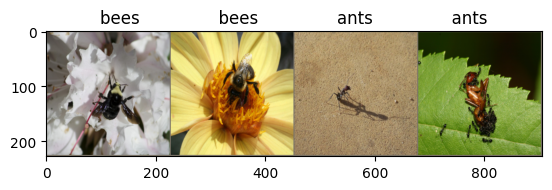

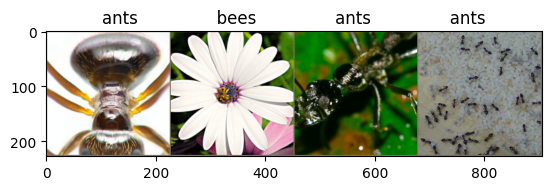

In [7]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # reconvert to numpy tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                  # take out normalization
    inp = np.clip(inp, 0, 1)                # clip values to [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.pause(0.001)                   # pause a bit so that plots are updated


# Get a batch of training data
x, classes = next(iter(train_dl))

# Make a grid from batch
space = " "*15
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title= space.join(class_names[c] for c in classes[:4]))

# Redo for valid data
x, classes = next(iter(val_dl))
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=space.join(class_names[c] for c in classes[:4]))

## Training the model

Now, let's write a general function to train a model. I here put the training loop and the evaluation loop in two distinct function to better structurize the code.

In [8]:
# Function to iterate over data while training
def train_one_epoch(model, train_dl, loss, optim, device):
    model.train()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        ### COMPLETE - 1 line expected ###
        optim.zero_grad()

        # forward
        ### COMPLETE - 3 lines expected ###
        outputs = model(x)
        preds = torch.argmax(outputs, 1)
        l = loss(outputs, y)

        # backward + optimize
        ### COMPLETE - 2 lines expected ###
        l.backward()
        optim.step()

        # statistics
        cur_loss += l.item() * x.size(0)
        cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(train_dl.dataset)
    epoch_acc = cur_acc.double() / len(train_dl.dataset)
    return epoch_loss, epoch_acc

# Function to iterate over data while evaluating
def eval_one_epoch(model, val_dl, loss, device):
    model.eval()  # Set model to evaluate mode
    cur_loss, cur_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)

            # forward pass, prediction and loss computation
            ### COMPLETE - 3 lines expected ###
            outputs = model(x)
            preds = torch.argmax(outputs, 1)
            l = loss(outputs, y)

            # statistics
            cur_loss += l.item() * x.size(0)
            cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(val_dl.dataset)
    epoch_acc = cur_acc.double() / len(val_dl.dataset)
    return epoch_loss, epoch_acc

def train_model(model, train_dl, val_dl, loss, optim, num_epochs=20):
    model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "temp_model.pt")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load("temp_model.pt"))
    return model

### Visualizing the model predictions

Here is a generic function to display predictions for a few images.
We will re-use it to generate saliency maps in the following.




In [9]:
def visualize_preds(model, num_images=4):
    space = " "*15
    was_training = model.training
    model.eval()
    with torch.no_grad():
        x, y = next(iter(val_dl))
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        preds = torch.argmax(outputs, 1)

        out = torchvision.utils.make_grid(x[:num_images].cpu())
        imshow(out, title=space.join(class_names[p] for p in preds[:num_images]))
    model.train(mode=was_training)

## Training a CNN from scratch
For this notebook we will use the simplest of the ResNet models, the ResNet18 ([link](https://arxiv.org/abs/1512.03385) to the paper).

To do so, we simply instantiate the model (``torchvision.models.resnet18(num_classes)``) as we used to do also for the Logistic regression and we train it for a few epochs. Remember as well to:


*   Select the Loss to employ
*   Instantiate an optimizer

The complete training (for 10 epochs) should take less than 1 min on GPU.





In [10]:
model = models.resnet18(num_classes=2)
model = model.to(device)

loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Train and evaluate
model = train_model(model, train_dl, val_dl, loss, optimizer,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6680 Acc: 0.5820
Val Loss: 0.7045 Acc: 0.4967

Epoch 1/9
----------
Train Loss: 0.6264 Acc: 0.6598
Val Loss: 0.6242 Acc: 0.6863

Epoch 2/9
----------
Train Loss: 0.5578 Acc: 0.7090
Val Loss: 0.8090 Acc: 0.5425

Epoch 3/9
----------
Train Loss: 0.5295 Acc: 0.7541
Val Loss: 1.5615 Acc: 0.4837

Epoch 4/9
----------
Train Loss: 0.5319 Acc: 0.7377
Val Loss: 0.5822 Acc: 0.7255

Epoch 5/9
----------
Train Loss: 0.4775 Acc: 0.7746
Val Loss: 0.6581 Acc: 0.6144

Epoch 6/9
----------
Train Loss: 0.4479 Acc: 0.7910
Val Loss: 1.4307 Acc: 0.5425

Epoch 7/9
----------
Train Loss: 0.4566 Acc: 0.7828
Val Loss: 0.5321 Acc: 0.7059

Epoch 8/9
----------
Train Loss: 0.3946 Acc: 0.8033
Val Loss: 0.6014 Acc: 0.7582

Epoch 9/9
----------
Train Loss: 0.3717 Acc: 0.8279
Val Loss: 0.8120 Acc: 0.6667

Training complete in 0m 52s
Best val Acc: 0.758170


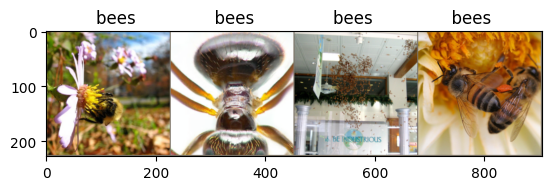

In [11]:
visualize_preds(model)

The model that we trained is not very accurate. Why? Because CNN are incredibly complex models and to be traned properly (without overfitting), they need to "see" a sufficiently large representation of the world. For this reason, most of the time we start at least from a network pretrained on the ImageNet dataset (1M samples).

## Finetune a CNN
To Finetune a CNN we need to do three steps:
*  Load the weights of the pretrained model: torchvision provides the weights pretrained Imagenet for each of the CNN implemented in the library (``weights=torchvision.models.ResNet18_Weights``).
*  Reset the final fully connected layer: to do so we initialize a linear layer ``nn.Linear()`` as the last layer of the model which is ``model_ft.fc``



In [12]:
from torchvision.models import ResNet18_Weights
model_ft = models.resnet18(ResNet18_Weights) ### COMPLETE  ###

# Here the model output size is set to 2
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 2) ### COMPLETE  ###

model_ft = model_ft.to(device)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=1e-4)  ### COMPLETE  ###)

# Train and evaluate
model_ft = train_model(model_ft, train_dl, val_dl, loss, optimizer_ft,
                       num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]

Epoch 0/9
----------


Train Loss: 0.4269 Acc: 0.7787
Val Loss: 0.2068 Acc: 0.9281

Epoch 1/9
----------
Train Loss: 0.0752 Acc: 0.9836
Val Loss: 0.2067 Acc: 0.9346

Epoch 2/9
----------
Train Loss: 0.0542 Acc: 0.9836
Val Loss: 0.2168 Acc: 0.9281

Epoch 3/9
----------
Train Loss: 0.0317 Acc: 0.9918
Val Loss: 0.1729 Acc: 0.9412

Epoch 4/9
----------
Train Loss: 0.0202 Acc: 0.9959
Val Loss: 0.1718 Acc: 0.9477

Epoch 5/9
----------
Train Loss: 0.0143 Acc: 1.0000
Val Loss: 0.1916 Acc: 0.9281

Epoch 6/9
----------
Train Loss: 0.0103 Acc: 1.0000
Val Loss: 0.1948 Acc: 0.9281

Epoch 7/9
----------
Train Loss: 0.0087 Acc: 1.0000
Val Loss: 0.1946 Acc: 0.9281

Epoch 8/9
----------
Train Loss: 0.0090 Acc: 1.0000
Val Loss: 0.2454 Acc: 0.9216

Epoch 9/9
----------
Train Loss: 0.0255 Acc: 0.9959
Val Loss: 0.2916 Acc: 0.8889

Training complete in 0m 37s
Best val Acc: 0.947712


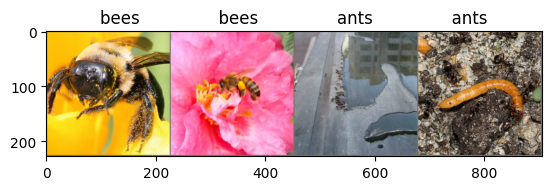

In [13]:
visualize_preds(model_ft)

Indeed it seems that pretraining is working effectively. We got a pretty good validation accuracy (>90%).

## ConvNet as fixed feature extractor
In this case we only train the last layer of the network. For this reason we need to:

*  Freeze all the network except the final layer, by seting ``requires_grad = False`` to freeze the parameters so that the gradients are not computed in ``backward()`` and speed up the computation. You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).
*  Pass to the optimizer only the weights of last layer ( ``model_fe.fc.parameters()``)

To train it will take less time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward still needs to be computed.


In [17]:
from torchvision.models import ResNet18_Weights
model_fe = models.resnet18(weights=ResNet18_Weights)

# Freeze network weights for all layers
for param in model_fe.parameters():
    ### COMPLETE - 1 line expected ###
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_fe.fc.in_features
model_fe.fc = torch.nn.Linear(num_ftrs, 2) ### COMPLETE ###

model_fe = model_fe.to(device)

# Only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.AdamW(model_fe.fc.parameters(), lr=1e-3) ### COMPLETE ###

# Train and evaluate
model_fe = train_model(model_fe, train_dl, val_dl, loss, optimizer_conv,
                         num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6386 Acc: 0.6393
Val Loss: 0.3811 Acc: 0.8824

Epoch 1/9
----------
Train Loss: 0.4061 Acc: 0.8279
Val Loss: 0.3384 Acc: 0.8954

Epoch 2/9
----------
Train Loss: 0.3012 Acc: 0.9180
Val Loss: 0.2400 Acc: 0.9346

Epoch 3/9
----------
Train Loss: 0.2742 Acc: 0.9303
Val Loss: 0.2860 Acc: 0.8889

Epoch 4/9
----------
Train Loss: 0.2445 Acc: 0.9221
Val Loss: 0.1916 Acc: 0.9542

Epoch 5/9
----------
Train Loss: 0.2027 Acc: 0.9344
Val Loss: 0.1858 Acc: 0.9542

Epoch 6/9
----------
Train Loss: 0.2169 Acc: 0.9221
Val Loss: 0.2240 Acc: 0.9085

Epoch 7/9
----------
Train Loss: 0.1809 Acc: 0.9426
Val Loss: 0.1665 Acc: 0.9608

Epoch 8/9
----------
Train Loss: 0.1580 Acc: 0.9672
Val Loss: 0.1858 Acc: 0.9281

Epoch 9/9
----------
Train Loss: 0.1361 Acc: 0.9631
Val Loss: 0.1601 Acc: 0.9542

Training complete in 0m 29s
Best val Acc: 0.960784


We actually got a better result with the CNN as Feature Extractor (about 95 %)!

This is most likely due to the fact that in the previous case we were strongly overfitting the data distribution. Indeed, by modifying also the hidden layers, the model at hand is incredibly complex for the small ant-bees dataset. Therefore if you have small dataset is better to only train the last fc layer.

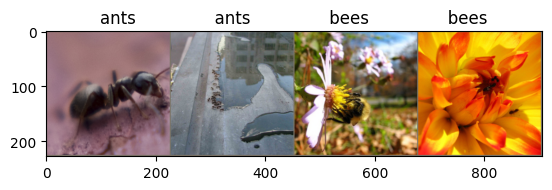

In [19]:
visualize_preds(model_fe)

plt.ioff()
plt.show()

## Long story short: avoid complexity if it is not required!

*   Start simple: transfer learning
*   Only if required: increase the complexity of your learning strategy adding finetuning and data augmentation.
*   Train from scratch a CNN: only when the data distribution is highly different from the one of pretrained dataset (e.g., tumoral cell detection)

###################################################################################################

 # Saliency Maps

 It's now time to visualize some explanations through a saliency map.
 Let's recall what is a saliency map.
 Given an image $X\in [0,1]^{C×H×W}$ (where $H$ is the height,  $W$ is the width, and $C$ is the number of channels), a saliency map $S \in [0,1]^{H×W}$ is an image where the brightness of the $(i,j)$ pixel, i.e., $S(i,j)$, represents how important or salient that pixel is in the network prediction. In other words, the greater the value of $S(i,j)$, the more important that pixel. If a particular region in the saliency map is concentrated with bright pixels, it means that the region or feature is important for prediction.


## Vanilla Gradient

Let's assume that $f^i(x)$ denotes the pre-softmax score (logit) of the
$i$-th class (there are a total of K classes). The prediction based on the output is given by

$$
k^*= argmax_{i\in[1, K]} f^i(x)$
$$

and $k^∗$ is the label of the class with the highest score. The algorithm first computes the vanilla gradients  as:


$$
G=\nabla_xf^{k^*}(x)= \frac{\delta f^{k^*}(x)}{\delta x}
$$

The vanilla gradients $G$ here is a matrix $\in \mathbb{R}^{C×H×W}$
representing the direction in which the score of the predicted class, i.e.,
$f^{k^∗}(x)$, increases. A positive gradient means that the pixel is important for increasing the predicted class score, while a negative or zero gradient means that the pixel is not important for the prediction. So it makes sense to only take positive gradients $G^+ = max⁡(0,G)$ for computing the saliency map.
The saliency map $S \in \mathbb{R}^{HxW}$  is now defined as the maximum value of the gradient $G^+$  along the channel dimension.


## Implementing Vanilla Gradient
Let's now implement the vanilla gradient.
To do so we will simply modify the visualization function to also output the gradients with respect to the predicted class.

Recall that the input `x` normally does not receive gradients (we do not want
our input to be modified during training!).

*   In this case however we will require gradients to flow until the input with `x.requires_grad = True`.
*   We will backgropagate the loss with respect to the 100% positive prediction of the predicted class  
*   We will extract the gradients from the input with `x.gradient`


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


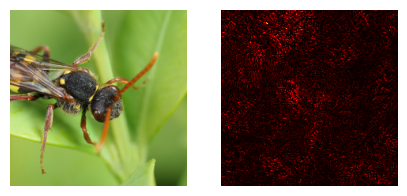

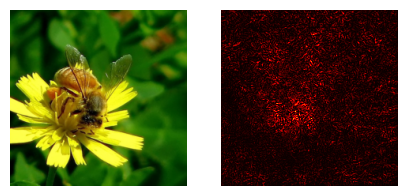

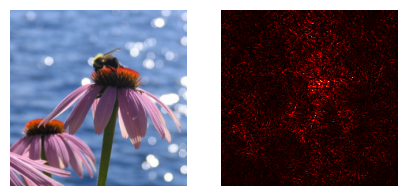

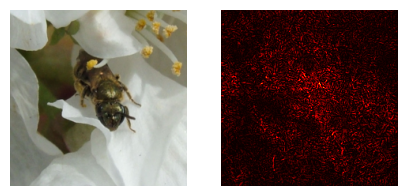

In [22]:
import cv2

model = model_fe
num_images = 4

# def vanilla_gradient(model, num_images=4):
space = " "*15
was_training = model.training
model.eval()
x, y = next(iter(val_dl))

x = x.to(device)
y = y.to(device)

# require gradient to flow until the input
x.requires_grad = True

outputs = model(x)
preds = torch.argmax(outputs, 1)

# backpropagate the loss with respect to the predicted class
optimizer.zero_grad()
l = loss(outputs, preds)
l.backward()

# extract gradient from the input
gradients = x.grad

# take positive values
gradients_pos = gradients.relu()

# take maximum over the channels (first dimension)
gradients_max, _ = torch.max(gradients_pos, 1)

inp = x.detach().cpu().numpy().transpose((-4, -2, -1, -3))  # reconvert to numpy tensor B x H x W x C
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean                  # take out normalization
inp = np.clip(inp, 0, 1)                # clip values to [0,1]

for i in range(num_images):
    fig, axes = plt.subplots(1, 2, figsize=(5,11))

    image = inp[i]
    # gradient = torch.max(gradients[i].relu(), 0)[0]
    gradient = gradients_max[i].cpu().detach().numpy()

    # plot the original image
    axes[0].imshow(image)

    # plot the gradients as a heatmap
    axes[1].imshow(gradient,  cmap=plt.cm.hot)

    axes[0].axis("off"), axes[1].axis('off')
    plt.show()

# if you pass the model_fe you need to require gradients on all layers as well
for param in model_fe.parameters():
    param.requires_grad = True



## How does our model perform?

Quite well, the highlighted pixels generally cover the *ant* or the *bee* in the image (Note: the results may vary according to the images that the val_dl returns, try to run it a few times to see other images)


**Problem**: the model however still focuses  on the *background*: this is a signal that even though the accuracy was high (>95\%) we cannot still trust completely the model.


Indeed we trained the model on too few images (and not many epochs too) to have a reliable model


## How do models trained on ImageNet perform?
To check if our previous assumption is true, let's check how the models trained on Imagenet perform on a standard image.

Upload the "dog.png" image to Colab (or put it in the same directory of your notebook if you are working locally) and execute the following cell.



In [23]:
from PIL import Image

orig_image = Image.open("dog.png").convert('RGB') # original image
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = transform(orig_image) # transform and normalize image
image.requires_grad = True

model = models.resnet18(ResNet18_Weights)
model.eval()

logits = model(image.unsqueeze(0))[0] # output logits, forward pass
prediction = torch.argmax(logits) # network prediction
# print("Model predicted : ", idx2label[prediction.item()])

grad = torch.autograd.grad(logits[prediction.item()], [image])[0] # backward pass
grad, _ = torch.max(grad.relu(), 0) # take positive gradients only

fig, axes = plt.subplots(1, 2, figsize=(5,11))

# plot the original image
axes[0].imshow(orig_image)

# plot the gradients as a heatmap
plt.imshow(grad, cmap=plt.cm.hot) # plot saliency
axes[0].axis("off"), axes[1].axis('off')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dog.png'